In [1]:
# %config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
import random
import seaborn as sns

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [3]:
class Dataset:
    def __init__(self, data_train_file, data_test_file, normalization_method='none'):
        """
        self.x_train                 ->     vector-x0 + data_x_train_normalized
        self.x_test                  ->     vector-x0 + data_x_test_normalized
        
        self.x_train_without_x0      ->     data_x_train_normalized
        self.x_test_without_x0       ->     data_x_test_normalized
        
        self.y_train                 ->     y_train
        self.y_test                  ->     y_test
        """
        self.coloumn_names = ['x1', 'x2', 'y']
        
        
        # read csv file using pandas
        self.data_train = pd.read_csv(data_train_file, names=self.coloumn_names)
        self.data_test = pd.read_csv(data_test_file, names=self.coloumn_names)
        
        # export y_train & y_test and convert to numpy array
        self.y_train = self.data_train['y'].to_numpy(dtype='float64').reshape(-1, 1)
        self.y_test = self.data_test['y'].to_numpy(dtype='float64').reshape(-1, 1)
        
        # remove y from x_train & x_test
        self.x_train_without_x0 = self.data_train.drop(['y'], axis=1).to_numpy(dtype='float64')
        self.x_test_without_x0 = self.data_test.drop(['y'], axis=1).to_numpy(dtype='float64')
        
        # required variables for model
        self.shape_of_x_train_without_x0 = self.x_train_without_x0.shape
        self.shape_of_x_test_without_x0 = self.x_test_without_x0.shape
        
        self.normalize(normalization_method)
        self.x_train = self.x_train_without_x0
        self.x_test = self.x_test_without_x0            
        
    """
    Normalizing data improves the convergence of learning model and causes that smaller features also be able to affect the model parameters.
    """
    def normalize(self, normalization_method):
        if normalization_method == 'none':
            print("No normalization.")
            return
        
        if normalization_method == 'zero_mean_unit_var':
            print("zero-mean & unit_variance normalization.")
            self.x_train_without_x0 = self.zero_mean_unit_variance(self.x_train_without_x0)
            self.x_test_without_x0 = self.zero_mean_unit_variance(self.x_test_without_x0)
            
            
        if normalization_method == 'scale_0_1':
            print("scaling to [0, 1] normalization.")
            self.x_train_without_x0 = self.scaling_between_0_1(self.x_train_without_x0)
            self.x_test_without_x0 = self.scaling_between_0_1(self.x_test_without_x0)
     
    
    def scaling_between_0_1(self, numpy_array):
        '''
        Scaling
        '''
        normed_numpy_array = (numpy_array - numpy_array.min(axis=0)) / (numpy_array.max(axis=0) - numpy_array.min(axis=0))
        return normed_numpy_array


    def zero_mean_unit_variance(self, numpy_array):
        '''
        Standardization
        '''
        normed_numpy_array = (numpy_array - numpy_array.mean(axis=0)) / numpy_array.std(axis=0)
        return normed_numpy_array


### Linear Discrimination Analysis 

In [220]:
class LDA():
    def fit(self, X , y):
        self.classes = np.unique(y)
        self.c = len(self.classes)
        self.m = X.shape[0]
        self.n = X.shape[1]  
    
        self.phi_MLE = self.phi(y)
        self.mean_MLE = self.mean(X, y)
        self.cov_MLE = self.cov(X, y, self.mean_MLE)
    
    def phi(self, y):
        phi_ = np.zeros(self.c)
        for i in range(self.c):
            phi_[i] = y[y == i].shape[0] / self.m
        phi_ = phi_.reshape(-1,1)
        return phi_
            
    def mean(self, x , y):
        mean_ = np.zeros((self.c, self.n))
        for i in range(self.c):
            mean_[i] = np.mean(x[np.argwhere(y == i)[:,0]], axis = 0)
        return mean_
    
    def cov(self, x, y, mean_MLE):
        cov_ = np.zeros((self.n, self.n))
        for i in range(self.m):
            temp = x[i] - mean_MLE[int(y[i])].reshape(1,-1)
            cov_ += np.dot(temp.T, temp)
        return cov_ / self.m
    
    def cov_class(self, x, y, mean_MLE):
        list_cov = []
        for class_ in range(self.c):
            cov_ = np.zeros((self.n, self.n))
            count_ = 0
            for i in range(x.shape[0]):
                if int(y[i]) == class_:
                    temp = x[i] - mean_MLE[int(y[i])].reshape(1,-1)
                    cov_ += np.dot(temp.T, temp)
                    count_ += 1
            cov_ /= count_
            list_cov.append(cov_)
        return list_cov
    
    def decision_boundary(self, x, i , j):
        diff_mean = (self.mean_MLE[i] - self.mean_MLE[j]).reshape(-1,1)
        a = np.linalg.pinv(self.cov_MLE) @ diff_mean
        
        mean_i = self.mean_MLE[i].reshape(-1,1)
        mean_j = self.mean_MLE[j].reshape(-1,1)
        b = -0.5*(mean_i.T @ np.linalg.pinv(self.cov_MLE) @ mean_i) + \
                0.5*(mean_j.T @ np.linalg.pinv(self.cov_MLE) @ mean_j) + \
                        np.log(self.phi_MLE[i]/self.phi_MLE[j])
        return -(b + a[0]*x) / a[1]
    
    def plot_decision(self, X, Y, label=None):
        fig2 = plt.figure()
        ax = fig2.gca()
        
        prediction = classifier.predict(X)
        
        color_ = [['.c','.r'],['.y','.k']]
        for class_ in range(self.c):
            missed = np.take(X, np.setdiff1d(np.where(prediction == class_), np.where(Y == class_)), axis=0)
            cl = np.delete(X, np.where(prediction != class_), axis=0)
            
            # can not parametized to n class
            ax.plot(cl[:, 0], cl[:, 1], color_[class_][0])
            ax.plot(missed[:, 0], missed[:, 1], color_[class_][1])
        
        x1 = X[:, 0]
        x = np.array([np.min(x1), np.max(x1)])
        y = self.decision_boundary(x, 0 , 1)
        ax.plot(x, y[0], label='decision boundary', color='green')
        
        x2 = np.array([np.min(X[:,1]), np.max(X[:,1])])
        ax.axis(ymin= x2[0]-0.5, ymax= x2[1]+0.5)
        ax.legend()
        return

    
    def plot_pdf(self, x_in, y_in, mean_MLE):
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        
        fig2 = plt.figure()
        ax2 = fig2.gca()
        
        color = ['viridis' ,'plasma', 'inferno']
        
        sigma = self.cov_class(x_in , y_in , mean_MLE)
        
        for class_ in range(self.c):
            #Create grid and multivariate normal            
            meow = [mean_MLE[class_][0], mean_MLE[class_][1]]     # :)
            sigma_c = sigma[class_]
            
            x = np.linspace(meow[0] - 4 * sigma_c[0][0], meow[0] + 4 * sigma_c[0][0], 200).flatten()
            y = np.linspace(meow[1] - 4 * sigma_c[1][1], meow[1] + 4 * sigma_c[1][1], 200).flatten()

            X, Y = np.meshgrid(x,y)
            pos = np.empty(X.shape + (2,))
            pos[:, :, 0] = X
            pos[:, :, 1] = Y

            rv = multivariate_normal(meow, sigma_c)

            #Make a 3D plot
            ax.plot_surface(X, Y, rv.pdf(pos), cmap=color[class_], linewidth=0)
            #Make contour
            ax2.contour(X, Y, rv.pdf(pos), cmap='inferno')
                        
        x_ = pd.DataFrame(data=x_in, columns=["x1", "x2"])
        y = pd.DataFrame(data=y_in, columns=["y"])

        res = pd.concat([x_, y], axis=1, sort=False)
        class_0 = res[res['y'] == 0]
        class_1 = res[res['y'] == 1]

        ax2.scatter(class_0.iloc[:,0], class_0.iloc[:, 1], s=10, label='class-0', c='#17becf')
        ax2.scatter(class_1.iloc[:,0], class_1.iloc[:, 1], s=10, label='class-1', c='#bcbd22')

        x1= x_in[:, 0]
        x = np.array([np.min(x1), np.max(x1)])
        y = self.decision_boundary(x, 0 , 1)
        ax2.plot(x, y[0], label='decision boundary', color='#2ca02c')
        
        x2_range = np.array([np.min(x_in[:,1]), np.max(x_in[:,1])])
        x1_range = np.array([np.min(x_in[:,0]), np.max(x_in[:,0])])
#         ax2.axis(ymin = -4, ymax=10, xmin = -2, xmax = 8)
        ax2.axis(ymin = x2_range[0]-0.5, ymax = x2_range[1]+0.5,\
                    xmin = x1_range[0]-0.5, xmax = x1_range[1]+0.5)
    
        data_join = np.c_[x_in, y_in]
        df = pd.DataFrame(data_join, columns = ['x1','x2','y'])
        sns.jointplot(data=df, x="x1", y="x2", hue="y", kind="kde", multiple='stack')
        

    def predict(self, x):
        probabilty = np.zeros((x.shape[0], self.c))
        for class_ in range(self.c):
            #[np.argwhere(y == class_)[:,0]]
            x_mean = (x - classifier.mean_MLE[class_])
            probabilty[:, class_] = (-0.5* np.sum(x_mean @ np.linalg.pinv(self.cov_MLE) @ x_mean.T, axis=1) +\
                                            np.log(self.phi_MLE[class_]))
        return np.argmax(probabilty, axis=1).reshape(-1,1)
    
#     def accuracy_metric(self, y_predict, y):
#         return (np.mean(y_predict == y))*100.0

    def compute_confusion_matrix(self, y_predict, y):
        """
                                              << confusion matrix >>
                                                   True labels
                    ____________________________________________________________________________
                    |                 class-0           class-1            class-2         ....|
                    |__________________________________________________________________________|
                    |                                                                          |
                    | class-0        **True-0**          False-0            False-0            |
predicted labels    |__________________________________________________________________________|
                    |                                                                          |
                    | class-1         False-1           **True-1**           False-1           |
                    |__________________________________________________________________________|
                    |                                                                          |
                    | class-2         False-2            False-2            **True-2**         |
                    |                                                                          |
                    .
                    .
                    .
        """
        confusion_matrix = np.zeros((self.c, self.c))
        
        for i in range(len(y)):
            # Truely predicted
            if int(y_predict[i][0]) == int(y[i][0]):
                true_label = int(y[i][0])
                confusion_matrix[true_label][true_label] += 1
            
            # Falsely predicted
            else:
                true_label = int(y[i][0])
                false_label = int(y_predict[i][0])
                confusion_matrix[false_label][true_label] += 1
        
        return confusion_matrix
    
    def F1_metric(self, y_predict, y):
        F1_arr = []
        confusion_matrix = self.compute_confusion_matrix(y_predict, y)
        for label in range(self.c):
            row = confusion_matrix[label, :]
            col = confusion_matrix[:, label]
            tmp = round(2*confusion_matrix[label, label] / (row.sum()+col.sum()), 2)
            F1_arr.append(tmp)
        return F1_arr
    
    def precision_metric(self, y_predict, y):
        precision_arr = []
        confusion_matrix = self.compute_confusion_matrix(y_predict, y)
        for label in range(self.c):
            row = confusion_matrix[label, :]
            tmp = round(confusion_matrix[label, label] / row.sum(), 2)
            precision_arr.append(tmp)
        return precision_arr
        
    def recall_metric(self, y_predict, y):
        recall_arr = []
        confusion_matrix = self.compute_confusion_matrix(y_predict, y)
        for label in range(self.c):
            col = confusion_matrix[:, label]
            tmp = round(confusion_matrix[label, label] / col.sum(), 2)
            recall_arr.append(tmp)
        return recall_arr
        pass
    
    def accuracy_metric(self, y_predict, y):
        confusion_matrix = self.compute_confusion_matrix(y_predict, y)
        diagonal_sum = confusion_matrix.trace()
        sum_of_all_elements = confusion_matrix.sum()
        return diagonal_sum * 100 / sum_of_all_elements 

No normalization.
Train:
accuracy:  99.0
precison:  [0.99, 0.99]
recall:  [0.99, 0.99]
F1:  [0.99, 0.99]
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
Test
accuracy:  100.0
precison:  [1.0, 1.0]
recall:  [1.0, 1.0]
F1:  [1.0, 1.0]


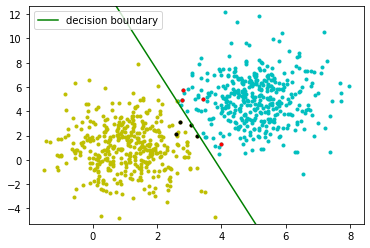

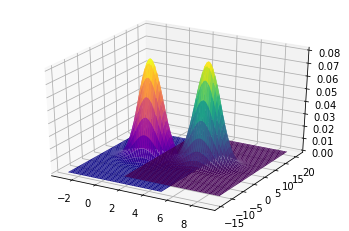

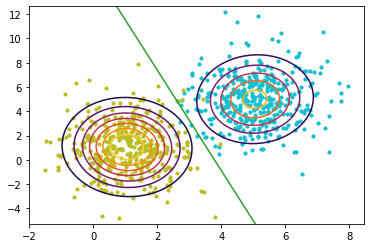

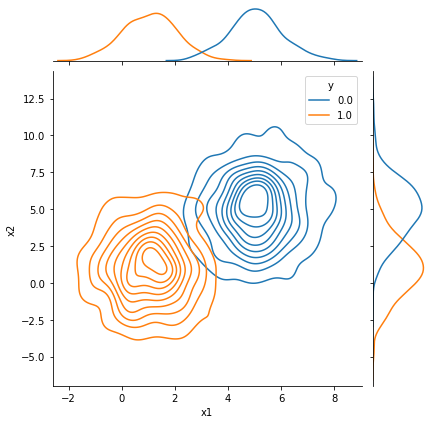

In [228]:
data = Dataset('BC-Train1.csv', 'BC-Test1.csv')

classifier = LDA()
classifier.fit(data.x_train, data.y_train)

# train
classifier.plot_decision(data.x_train, data.y_train)

classifier.plot_pdf(data.x_train, data.y_train, classifier.mean_MLE)


pred = classifier.predict(data.x_train)

print('Train:')
classifier.compute_confusion_matrix(pred, data.y_train)
print('accuracy: ',classifier.accuracy_metric(pred, data.y_train))
print('precison: ',classifier.precision_metric(pred, data.y_train))
print('recall: ',classifier.recall_metric(pred, data.y_train))
print('F1: ',classifier.F1_metric(pred, data.y_train))

print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.")
print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.")
#test
pred = classifier.predict(data.x_test)
print('Test')
classifier.compute_confusion_matrix(pred, data.y_test)
print('accuracy: ',classifier.accuracy_metric(pred, data.y_test))
print('precison: ',classifier.precision_metric(pred, data.y_test))
print('recall: ',classifier.recall_metric(pred, data.y_test))
print('F1: ',classifier.F1_metric(pred, data.y_test))

TEST :


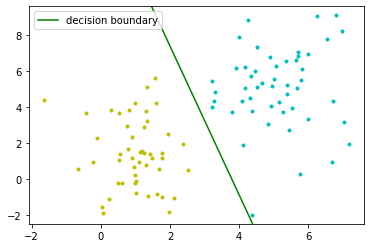

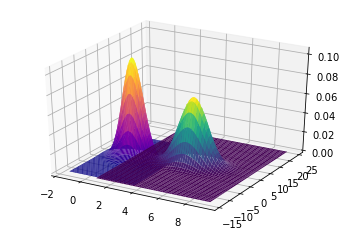

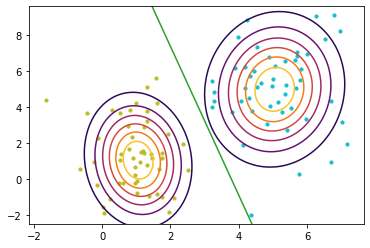

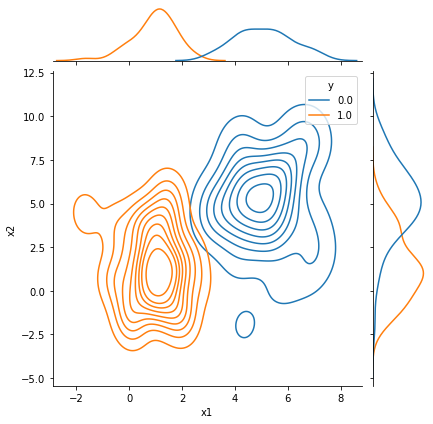

In [132]:
# test
print('TEST :')
classifier.plot_decision(data.x_test, data.y_test)

classifier.plot_pdf(data.x_test, data.y_test, classifier.mean_MLE)

No normalization.
Train:
accuracy:  99.125
precison:  [0.98, 1.0]
recall:  [1.0, 0.98]
F1:  [0.99, 0.99]
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
Test
accuracy:  100.0
precison:  [1.0, 1.0]
recall:  [1.0, 1.0]
F1:  [1.0, 1.0]


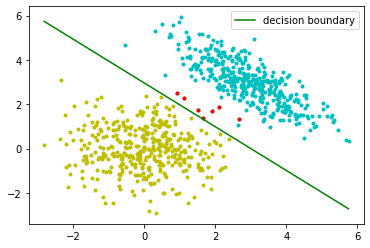

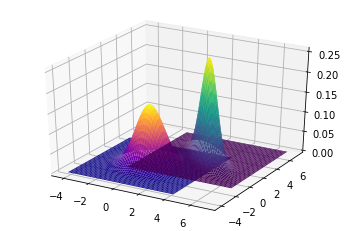

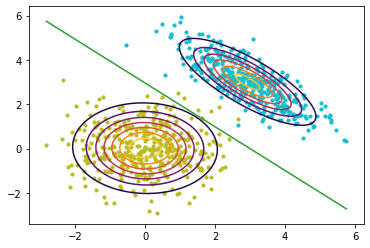

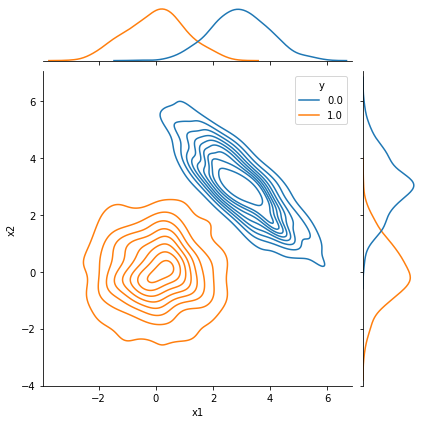

In [230]:
data = Dataset('BC-Train2.csv', 'BC-Test2.csv')

classifier = LDA()
classifier.fit(data.x_train, data.y_train)

# train
classifier.plot_decision(data.x_train, data.y_train)

classifier.plot_pdf(data.x_train, data.y_train, classifier.mean_MLE)


pred = classifier.predict(data.x_train)

print('Train:')
classifier.compute_confusion_matrix(pred, data.y_train)
print('accuracy: ',classifier.accuracy_metric(pred, data.y_train))
print('precison: ',classifier.precision_metric(pred, data.y_train))
print('recall: ',classifier.recall_metric(pred, data.y_train))
print('F1: ',classifier.F1_metric(pred, data.y_train))

print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.")
print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.")
#test
pred = classifier.predict(data.x_test)
print('Test')
classifier.compute_confusion_matrix(pred, data.y_test)
print('accuracy: ',classifier.accuracy_metric(pred, data.y_test))
print('precison: ',classifier.precision_metric(pred, data.y_test))
print('recall: ',classifier.recall_metric(pred, data.y_test))
print('F1: ',classifier.F1_metric(pred, data.y_test))

TEST :


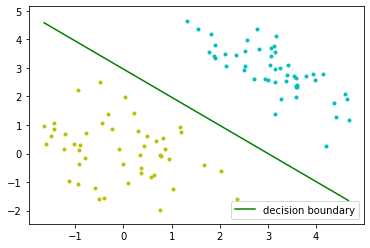

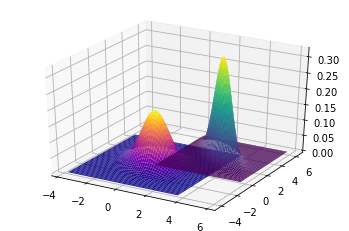

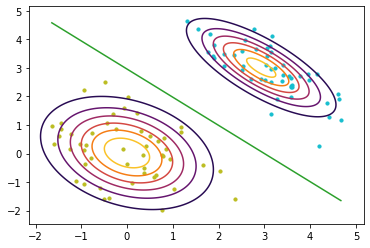

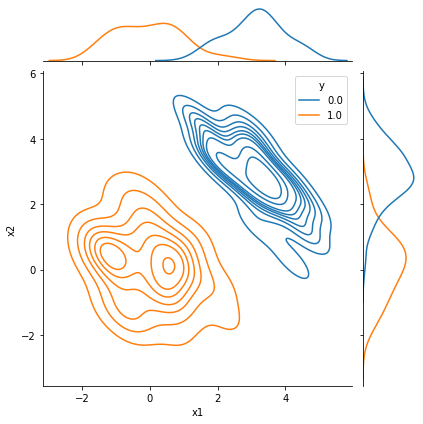

In [210]:
# test
print('TEST :')
classifier.plot_decision(data.x_test, data.y_test)

classifier.plot_pdf(data.x_test, data.y_test, classifier.mean_MLE)

## create dataset

* Create dataset with a number of sample from multivariate Gaussian Distribution

* This is called multi-variant because we need more than 1 feature variable. Here two, [x1, x2]

* Multivariate Gaussian is expressed as:
> $$ P(x) = \frac {1} {(2\pi)^{D/2} |\sum|^{1/2}} \  \exp (\frac {-1} {2} (x-\mu)^T |\sum|^{-1} (x-\mu))$$

* while:
    * $ D $ is the number of dimentions
    * $ \sum $ is the covariance matrix
    * $ \mu $ is the mean
    * $ x $ is the variable

In [100]:
# imports

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split

In [143]:
# dataset creation

class DatasetGD():
    """
    if split_test_train == True:
        access data by "x_train", "y_train", "x_test", "y_test"
    else:
        access data by "x", "y"
    """
    def __init__(self, num_of_samples, mean, covariance, num_of_classes, 
                 shuffle=True, split_test_train=True, test_size=0.2):
        self.num_of_samples = num_of_samples
        self.mean = mean
        self.covariance = covariance
        self.num_of_classes = num_of_classes
        
        self.generate_dataset(num_of_samples, mean, covariance, num_of_classes)
        
        # split test train dataset
        if split_test_train == True:
            self.split(shuffle, test_size)   
            
    def split(self, shuffle, test_size):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=test_size, shuffle=shuffle)
     
    def generate_dataset(self, num_of_samples, mean, covariance, num_of_classes, seed=1000):
        x_data = []        
        y_data = []
        for i in range(self.num_of_classes):
            self.mvd = multivariate_normal(cov = covariance[i], mean = mean[i], seed = seed)
            
            # generating 500 samples out of the distribution
            x_tmp = self.mvd.rvs(size = num_of_samples)
            y_tmp = np.array([i]*self.num_of_samples)
        
            x_data.append(x_tmp)
            y_data.append(y_tmp)
        
        # concatenate all x_datas and y_datas
        self.x = list(x_data[0]) + list(x_data[1]) + list(x_data[2])
        self.y = list(y_data[0]) + list(y_data[1]) + list(y_data[2])
        self.x = np.array(self.x)
        self.y = np.array(self.y).reshape(-1, 1)
    
    def plot_dataset(self):
        colors = ['red','green','blue']

        fig = plt.figure(figsize=(8,8))
        plt.scatter(self.x[:, 0], self.x[:, 1], c=self.y, cmap=matplotlib.colors.ListedColormap(colors))

        cb = plt.colorbar()
        loc = np.arange(0,max(self.y),max(self.y)/float(len(colors)))
        cb.set_ticks(loc)
        cb.set_ticklabels(colors)


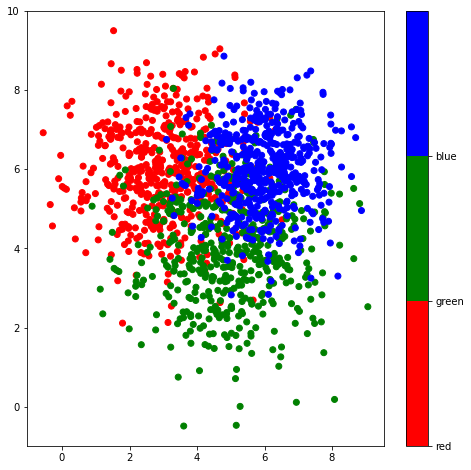

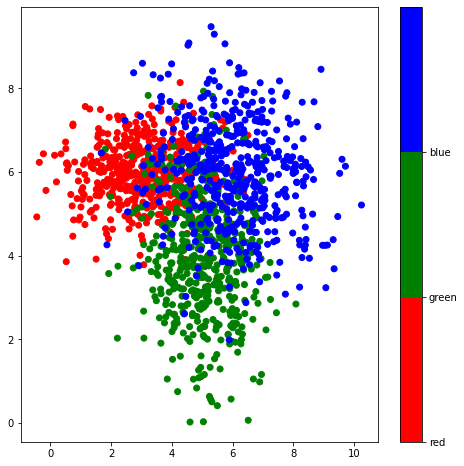

In [151]:
mean_1_class_1 = [3, 6]
covariance_1_class_1 = np.array([[1.5, 0], 
                                 [0, 1.5]])
mean_1_class_2 = [5, 4]
covariance_1_class_2 = np.array([[2, 0], 
                                 [0, 2]])
mean_1_class_3 = [6, 6]
covariance_1_class_3 = np.array([[1, 0], 
                                 [0, 1]])

mean_1 = []
mean_1.append(mean_1_class_1)
mean_1.append(mean_1_class_2)
mean_1.append(mean_1_class_3)

covariance_1 = []
covariance_1.append(covariance_1_class_1)
covariance_1.append(covariance_1_class_2)
covariance_1.append(covariance_1_class_3)
# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
mean_2_class_1 = [3, 6]
covariance_2_class_1 = np.array([[1.5, 0.1], 
                                 [0.1, 0.5]])
mean_2_class_2 = [5, 4]
covariance_2_class_2 = np.array([[1, -0.2], 
                                 [-0.2, 2]])
mean_2_class_3 = [6, 6]
covariance_2_class_3 = np.array([[2, -0.25], 
                                 [-0.25, 1.5]])

mean_2 = []
mean_2.append(mean_2_class_1)
mean_2.append(mean_2_class_2)
mean_2.append(mean_2_class_3)

covariance_2 = []
covariance_2.append(covariance_2_class_1)
covariance_2.append(covariance_2_class_2)
covariance_2.append(covariance_2_class_3)
# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

dataset_1 = DatasetGD(num_of_samples=500, mean=mean_1, covariance=covariance_1, num_of_classes=3, split_test_train=True, test_size=0.2)
dataset_1.plot_dataset()
dataset_2 = DatasetGD(num_of_samples=500, mean=mean_2, covariance=covariance_2, num_of_classes=3, split_test_train=True, test_size=0.2)
dataset_2.plot_dataset()


In [103]:
print(dataset_1.x_train.shape)
print(dataset_1.y_train.shape)

print(dataset_1.x_test.shape)
print(dataset_1.y_test.shape)

(1200, 2)
(1200, 1)
(300, 2)
(300, 1)


### Quadratic Discrimination Analysis 

In [334]:
class QDA():
    def fit(self, X , y):
        self.classes = np.unique(y)
        self.c = len(self.classes)
        self.m = X.shape[0]
        self.n = X.shape[1]  
    
        self.phi_MLE = self.phi(y)
        self.mean_MLE = self.mean(X, y)
        self.cov_MLE = self.cov_class(X, y, self.mean_MLE)
    
    def phi(self, y):
        phi_ = np.zeros(self.c)
        for i in range(self.c):
            phi_[i] = y[y == i].shape[0] / self.m
        phi_ = phi_.reshape(-1,1)
        return phi_
            
    def mean(self, x , y):
        mean_ = np.zeros((self.c, self.n))
        for i in range(self.c):
            mean_[i] = np.mean(x[np.argwhere(y == i)[:,0]], axis = 0)
        return mean_
    
    def cov_class(self, x, y, mean_MLE):
        list_cov = []
        for class_ in range(self.c):
            cov_ = np.zeros((self.n, self.n))
            count_ = 0
            for i in range(x.shape[0]):
                if int(y[i]) == class_:
                    temp = x[i] - mean_MLE[int(y[i])].reshape(1,-1)
                    cov_ += np.dot(temp.T, temp)
                    count_ += 1
            cov_ /= count_
            list_cov.append(cov_)
        return list_cov
    
    def decision_boundary(self, x, y, i , j):
        
        temp =  np.argwhere(y == i)[:,0].tolist() 
        temp +=(np.argwhere(y == j)[:,0].tolist())
        indexs = np.array(sorted(set(temp)))
        X = x[indexs]
        x = np.arange(X.min(axis=0)[0], X.max(axis=0)[0], 0.2)
        det_i = np.linalg.det(self.cov_MLE[i])
        det_j = np.linalg.det(self.cov_MLE[j])
        inv_i = np.linalg.pinv(self.cov_MLE[i])
        inv_j = np.linalg.pinv(self.cov_MLE[j])
        mu_i  = self.mean_MLE[i]
        mu_j  = self.mean_MLE[j]
        a = -0.5 * (inv_i - inv_j)
        b = (inv_i @ mu_i.T) - (inv_j @ mu_j.T)
        c = np.log(self.phi_MLE[i]/self.phi_MLE[j]) - 1/2 * np.log(det_i/det_j)
        c = c + (-0.5 * (mu_i @ inv_i) @ mu_i.T) + (0.5 * (mu_j @ inv_j) @ mu_j.T)

        a1 = a[0,0]
        a2 = a[0,1]
        a3 = a[1,0]
        a4 = a[1,1]
        b1 = b[0]
        b2 = b[1]
        c = c[0]
        return a1,a2,a3,a4,b1,b2,c
    
    
    def plot_decision(self, X, Y, label=None):
        fig2 = plt.figure()
        ax = fig2.gca()
        
        prediction = classifier.predict(X)
        
        color_ = [['.c','.r'],['xy','xk'],['+g', '+m']]
        for class_ in range(self.c):
            missed = np.take(X, np.setdiff1d(np.where(prediction == class_), np.where(Y == class_)), axis=0)
            cl = np.delete(X, np.where(prediction != class_), axis=0)
            
            ax.plot(cl[:, 0], cl[:, 1], color_[class_][0])
            ax.plot(missed[:, 0], missed[:, 1], color_[class_][1])
        
        a1,a2,a3,a4,b1,b2,c = self.decision_boundary(X, Y, 0 , 1)
        x1 = np.linspace(-1,10,1000)
        x2 = np.linspace(-1,10,1000)
        
#         min_x01 = min(X[np.argwhere(Y == 0)[:,0]].min(axis=0)[0] , X[np.argwhere(Y == 1)[:,0]].min(axis=0)[0])
#         max_x01 = max(X[np.argwhere(Y == 0)[:,0]].max(axis=0)[0] , X[np.argwhere(Y == 1)[:,0]].max(axis=0)[0])
#         print('0 ',min_x01, max_x01)  
#         x1 = np.linspace(min_x01, max_x01, 1000)
        
#         min_x01 = min(X[np.argwhere(Y == 0)[:,0]].min(axis=1)[0] , X[np.argwhere(Y == 1)[:,0]].min(axis=1)[0])
#         max_x01 = max(X[np.argwhere(Y == 0)[:,0]].max(axis=1)[0] , X[np.argwhere(Y == 1)[:,0]].max(axis=1)[0])
#         print('1 ',min_x01, max_x01)
#         x2 = np.linspace(min_x01, max_x01, 1000)
        
        x1, x2 = np.meshgrid(x1,x2)
        F = x1**2* a1 + x1*x2*a3 + x1*x2*a2 + x2**2 * a4 + b1*x1 + b2*x2 + c
        ax.contour(x1,x2,F,[0], cmap='spring')
        
        
        
        
        a1,a2,a3,a4,b1,b2,c = self.decision_boundary(X, Y, 0 , 2)
        x1 = np.linspace(-1,10,1000)
        x2 = np.linspace(-1,10,1000)
        
#         min_x01 = min(X[np.argwhere(Y == 0)[:,0]].min(axis=0)[0] , X[np.argwhere(Y == 2)[:,0]].min(axis=0)[0])
#         max_x01 = max(X[np.argwhere(Y == 0)[:,0]].max(axis=0)[0] , X[np.argwhere(Y == 2)[:,0]].max(axis=0)[0])
#         print('0 ',min_x01, max_x01)  
#         x1 = np.linspace(min_x01, max_x01, 1000)
        
#         min_x01 = min(X[np.argwhere(Y == 0)[:,0]].min(axis=1)[0] , X[np.argwhere(Y == 2)[:,0]].min(axis=1)[0])
#         max_x01 = max(X[np.argwhere(Y == 0)[:,0]].max(axis=1)[0] , X[np.argwhere(Y == 2)[:,0]].max(axis=1)[0])
#         print('1 ',min_x01, max_x01)
#         x2 = np.linspace(min_x01, max_x01, 1000)
        
        x1, x2 = np.meshgrid(x1,x2)
        F = x1**2* a1 + x1*x2*a3 + x1*x2*a2 + x2**2 * a4 + b1*x1 + b2*x2 + c
        ax.contour(x1,x2,F,[0], cmap='winter')
        
        
        
        a1,a2,a3,a4,b1,b2,c = self.decision_boundary(X, Y, 1 , 2)
        x1 = np.linspace(-1,10,1000)
        x2 = np.linspace(-1,10,1000)
        
#         min_x01 = min(X[np.argwhere(Y == 1)[:,0]].min(axis=0)[0] , X[np.argwhere(Y == 2)[:,0]].min(axis=0)[0])
#         max_x01 = max(X[np.argwhere(Y == 1)[:,0]].max(axis=0)[0] , X[np.argwhere(Y == 2)[:,0]].max(axis=0)[0])
#         print('0 ',min_x01, max_x01)  
#         x1 = np.linspace(min_x01, max_x01, 1000)
        
#         min_x01 = min(X[np.argwhere(Y == 1)[:,0]].min(axis=1)[0] , X[np.argwhere(Y == 2)[:,0]].min(axis=1)[0])
#         max_x01 = max(X[np.argwhere(Y == 1)[:,0]].max(axis=1)[0] , X[np.argwhere(Y == 2)[:,0]].max(axis=1)[0])
#         print('1 ',min_x01, max_x01)
#         x2 = np.linspace(min_x01, max_x01, 1000)
        
        x1, x2 = np.meshgrid(x1,x2)
        F = x1**2* a1 + x1*x2*a3 + x1*x2*a2 + x2**2 * a4 + b1*x1 + b2*x2 + c
        ax.contour(x1,x2,F,[0], cmap='autumn')
        
        
        x2_range = np.array([np.min(X[:,1]), np.max(X[:,1])])
        x1_range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        ax.axis(ymin = x2_range[0]-0.5, ymax = x2_range[1]+0.5,\
                    xmin = x1_range[0]-0.5, xmax = x1_range[1]+0.5)
        return

    
    def plot_pdf(self, x_in, y_in, mean_MLE):
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        
        fig2 = plt.figure()
        ax2 = fig2.gca()
        
        color = ['viridis' ,'plasma', 'cividis']
        
        sigma = self.cov_class(x_in , y_in , mean_MLE)
        
        for class_ in range(self.c):
            meow = [mean_MLE[class_][0], mean_MLE[class_][1]]     # :)
            sigma_c = sigma[class_]
            
            x = np.linspace(meow[0] - 4 * sigma_c[0][0], meow[0] + 4 * sigma_c[0][0], 200).flatten()
            y = np.linspace(meow[1] - 4 * sigma_c[1][1], meow[1] + 4 * sigma_c[1][1], 200).flatten()

            X, Y = np.meshgrid(x,y)
            pos = np.empty(X.shape + (2,))
            pos[:, :, 0] = X
            pos[:, :, 1] = Y

            rv = multivariate_normal(meow, sigma_c)

            #Make a 3D plot
            ax.plot_surface(X, Y, rv.pdf(pos), cmap=color[class_], linewidth=0)
            #Make contour
            ax2.contour(X, Y, rv.pdf(pos), cmap='inferno')
                    
                        
        x_ = pd.DataFrame(data=x_in, columns=["x1", "x2"])
        y = pd.DataFrame(data=y_in, columns=["y"])

        res = pd.concat([x_, y], axis=1, sort=False)
        class_0 = res[res['y'] == 0]
        class_1 = res[res['y'] == 1]
        class_2 = res[res['y'] == 2]

        ax2.scatter(class_0.iloc[:,0], class_0.iloc[:, 1], s=10, label='class-0', c='#17becf')
        ax2.scatter(class_1.iloc[:,0], class_1.iloc[:, 1], s=10, label='class-1', c='#bcbd22')
        ax2.scatter(class_2.iloc[:,0], class_2.iloc[:, 1], s=10, label='class-2', c='#8c564b')

        a1,a2,a3,a4,b1,b2,c = self.decision_boundary(x_in, y_in, 0 , 1)
        x1 = np.linspace(-1,10,1000)
        x2 = np.linspace(-1,10,1000)
        x1, x2 = np.meshgrid(x1,x2)
        F = x1**2* a1 + x1*x2*a3 + x1*x2*a2 + x2**2 * a4 + b1*x1 + b2*x2 + c
        ax2.contour(x1,x2,F,[0], cmap='spring')
        

        a1,a2,a3,a4,b1,b2,c = self.decision_boundary(x_in, y_in, 0 , 2)
        x1 = np.linspace(-1,10,1000)
        x2 = np.linspace(-1,10,1000)
        x1, x2 = np.meshgrid(x1,x2)
        F = x1**2* a1 + x1*x2*a3 + x1*x2*a2 + x2**2 * a4 + b1*x1 + b2*x2 + c
        ax2.contour(x1,x2,F,[0], cmap='winter')
            
        
        a1,a2,a3,a4,b1,b2,c = self.decision_boundary(x_in, y_in, 1 , 2)
        x1 = np.linspace(-1,10,1000)
        x2 = np.linspace(-1,10,1000)
        x1, x2 = np.meshgrid(x1,x2)
        F = x1**2* a1 + x1*x2*a3 + x1*x2*a2 + x2**2 * a4 + b1*x1 + b2*x2 + c
        ax2.contour(x1,x2,F,[0], cmap='autumn')
        
        
        x2_range = np.array([np.min(x_in[:,1]), np.max(x_in[:,1])])
        x1_range = np.array([np.min(x_in[:,0]), np.max(x_in[:,0])])
        ax2.axis(ymin = x2_range[0]-0.5, ymax = x2_range[1]+0.5,\
                    xmin = x1_range[0]-0.5, xmax = x1_range[1]+0.5)
    
        data_join = np.c_[x_in, y_in]
        df = pd.DataFrame(data_join, columns = ['x1','x2','y'])
        sns.jointplot(data=df, x="x1", y="x2", hue="y", kind="kde", multiple='stack')
        

    def predict(self, x):
        probabilty = np.zeros((x.shape[0], self.c))
        for class_ in range(self.c):
            x_mean = (x - classifier.mean_MLE[class_])
            probabilty[:, class_] = (-0.5* np.sum(x_mean @ np.linalg.pinv(self.cov_MLE[class_]) @ x_mean.T, axis=1) +\
                                            np.log(self.phi_MLE[class_]) - 0.5*np.log(np.linalg.det(self.cov_MLE[class_])))
        return np.argmax(probabilty, axis=1).reshape(-1,1)    
    
#     def accuracy_metric(self, y_predict, y):
#         return (np.mean(y_predict == y))*100.0

    def compute_confusion_matrix(self, y_predict, y):
        """
                                              << confusion matrix >>
                                                   True labels
                    ____________________________________________________________________________
                    |                 class-0           class-1            class-2         ....|
                    |__________________________________________________________________________|
                    |                                                                          |
                    | class-0        **True-0**          False-0            False-0            |
predicted labels    |__________________________________________________________________________|
                    |                                                                          |
                    | class-1         False-1           **True-1**           False-1           |
                    |__________________________________________________________________________|
                    |                                                                          |
                    | class-2         False-2            False-2            **True-2**         |
                    |                                                                          |
                    .
                    .
                    .
        """
        confusion_matrix = np.zeros((self.c, self.c))
        
        for i in range(len(y)):
            # Truely predicted
            if int(y_predict[i][0]) == int(y[i][0]):
                true_label = int(y[i][0])
                confusion_matrix[true_label][true_label] += 1
            
            # Falsely predicted
            else:
                true_label = int(y[i][0])
                false_label = int(y_predict[i][0])
                confusion_matrix[false_label][true_label] += 1
        
        return confusion_matrix
    
    def F1_metric(self, y_predict, y):
        F1_arr = []
        confusion_matrix = self.compute_confusion_matrix(y_predict, y)
        for label in range(self.c):
            row = confusion_matrix[label, :]
            col = confusion_matrix[:, label]
            tmp = round(2*confusion_matrix[label, label] / (row.sum()+col.sum()), 2)
            F1_arr.append(tmp)
        return F1_arr
    
    def precision_metric(self, y_predict, y):
        precision_arr = []
        confusion_matrix = self.compute_confusion_matrix(y_predict, y)
        for label in range(self.c):
            row = confusion_matrix[label, :]
            tmp = round(confusion_matrix[label, label] / row.sum(), 2)
            precision_arr.append(tmp)
        return precision_arr
        
    def recall_metric(self, y_predict, y):
        recall_arr = []
        confusion_matrix = self.compute_confusion_matrix(y_predict, y)
        for label in range(self.c):
            col = confusion_matrix[:, label]
            tmp = round(confusion_matrix[label, label] / col.sum(), 2)
            recall_arr.append(tmp)
        return recall_arr
        pass
    
    def accuracy_metric(self, y_predict, y):
        confusion_matrix = self.compute_confusion_matrix(y_predict, y)
        diagonal_sum = confusion_matrix.trace()
        sum_of_all_elements = confusion_matrix.sum()
        return diagonal_sum * 100 / sum_of_all_elements 

In [311]:
dataset_1 = DatasetGD(num_of_samples=500, mean=mean_1, covariance=covariance_1, num_of_classes=3, split_test_train=True, test_size=0.2)


Train:
accuracy:  75.25
precison:  [0.84, 0.65, 0.8]
recall:  [0.77, 0.77, 0.72]
F1:  [0.8, 0.7, 0.76]
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
Test
accuracy:  78.66666666666667
precison:  [0.93, 0.7, 0.75]
recall:  [0.82, 0.78, 0.76]
F1:  [0.87, 0.74, 0.75]


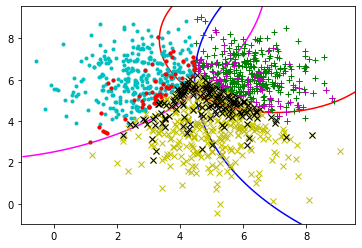

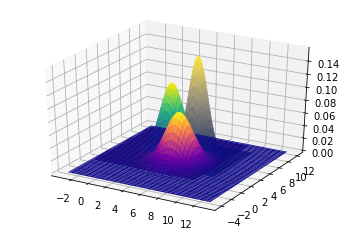

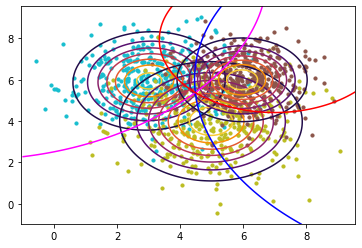

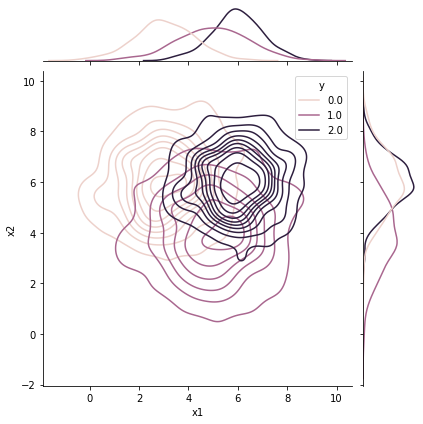

In [335]:

classifier = QDA()
classifier.fit(dataset_1.x_train, dataset_1.y_train)

# train
classifier.plot_decision(dataset_1.x_train, dataset_1.y_train)

classifier.plot_pdf(dataset_1.x_train, dataset_1.y_train, classifier.mean_MLE)

pred = classifier.predict(dataset_1.x_train)

print('Train:')
classifier.compute_confusion_matrix(pred, dataset_1.y_train)
print('accuracy: ',classifier.accuracy_metric(pred, dataset_1.y_train))
print('precison: ',classifier.precision_metric(pred, dataset_1.y_train))
print('recall: ',classifier.recall_metric(pred, dataset_1.y_train))
print('F1: ',classifier.F1_metric(pred, dataset_1.y_train))

print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.")
print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.")
#test
pred = classifier.predict(dataset_1.x_test)
print('Test')
classifier.compute_confusion_matrix(pred, dataset_1.y_test)
print('accuracy: ',classifier.accuracy_metric(pred, dataset_1.y_test))
print('precison: ',classifier.precision_metric(pred, dataset_1.y_test))
print('recall: ',classifier.recall_metric(pred, dataset_1.y_test))
print('F1: ',classifier.F1_metric(pred, dataset_1.y_test))

TEST :


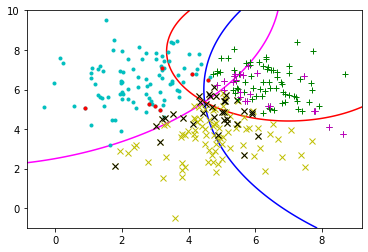

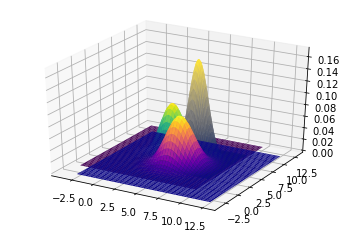

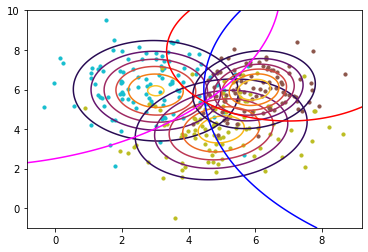

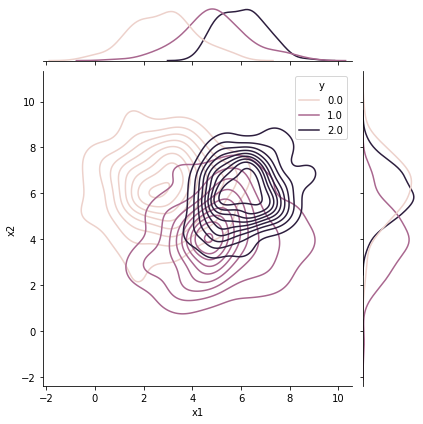

In [336]:
# test
print('TEST :')
classifier.plot_decision(dataset_1.x_test, dataset_1.y_test)

classifier.plot_pdf(dataset_1.x_test, dataset_1.y_test, classifier.mean_MLE)

In [359]:
dataset_2 = DatasetGD(num_of_samples=500, mean=mean_2, covariance=covariance_2, num_of_classes=3, split_test_train=True, test_size=0.2)


Train:
accuracy:  75.83333333333333
precison:  [0.81, 0.7, 0.78]
recall:  [0.74, 0.84, 0.7]
F1:  [0.77, 0.77, 0.73]
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
Test
accuracy:  77.33333333333333
precison:  [0.87, 0.77, 0.68]
recall:  [0.78, 0.84, 0.69]
F1:  [0.82, 0.8, 0.69]


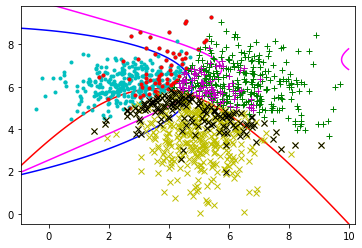

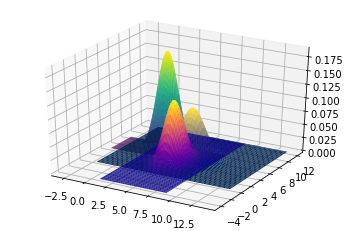

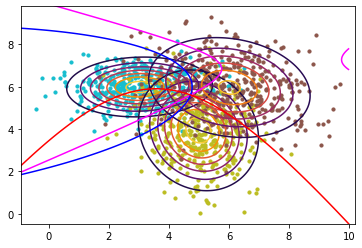

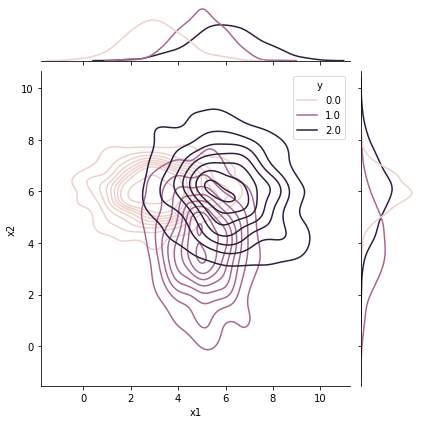

In [360]:

classifier = QDA()
classifier.fit(dataset_2.x_train, dataset_2.y_train)

# train
classifier.plot_decision(dataset_2.x_train, dataset_2.y_train)

classifier.plot_pdf(dataset_2.x_train, dataset_2.y_train, classifier.mean_MLE)

pred = classifier.predict(dataset_2.x_train)

print('Train:')
classifier.compute_confusion_matrix(pred, dataset_2.y_train)
print('accuracy: ',classifier.accuracy_metric(pred, dataset_2.y_train))
print('precison: ',classifier.precision_metric(pred, dataset_2.y_train))
print('recall: ',classifier.recall_metric(pred, dataset_2.y_train))
print('F1: ',classifier.F1_metric(pred, dataset_2.y_train))

print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.")
print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.")
#test
pred = classifier.predict(dataset_2.x_test)
print('Test')
classifier.compute_confusion_matrix(pred, dataset_2.y_test)
print('accuracy: ',classifier.accuracy_metric(pred, dataset_2.y_test))
print('precison: ',classifier.precision_metric(pred, dataset_2.y_test))
print('recall: ',classifier.recall_metric(pred, dataset_2.y_test))
print('F1: ',classifier.F1_metric(pred, dataset_2.y_test))

TEST :


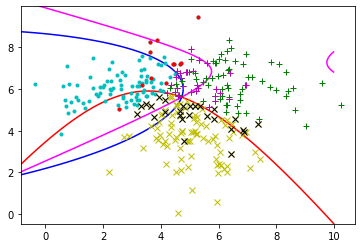

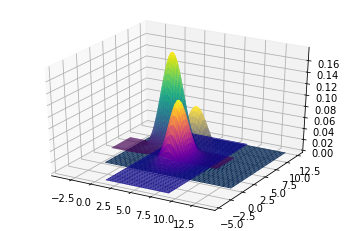

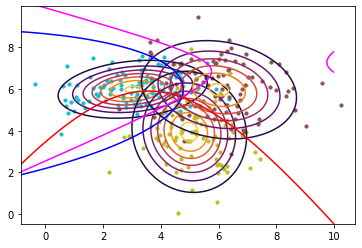

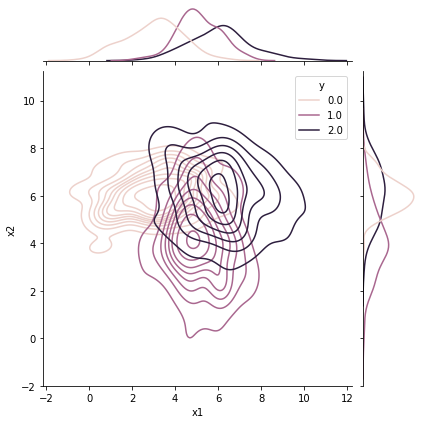

In [361]:
# test
print('TEST :')
classifier.plot_decision(dataset_2.x_test, dataset_2.y_test)

classifier.plot_pdf(dataset_2.x_test, dataset_2.y_test, classifier.mean_MLE)